### Introduction

This article gives a detailed explanation of the weight vector updates in word2vec C implementation.

### some properties of sigmoid function

(0)

$$
\sigma' (y) = \sigma (y) \cdot [ 1 - \sigma (y) ] \cdot y'
$$

#### visualize a property of sigmoid function

$$
\frac {1} {N} \sum_{i=1}^{N} \sigma(x_i) \approx
\sigma( \frac {1} {N} \sum_{i=1}^{N} x_i )
$$

I can't prove it, my major is not math

Populating the interactive namespace from numpy and matplotlib


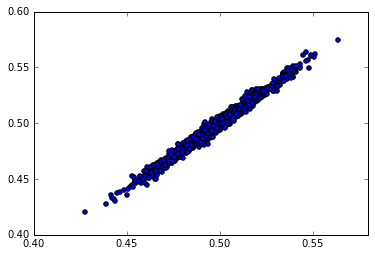

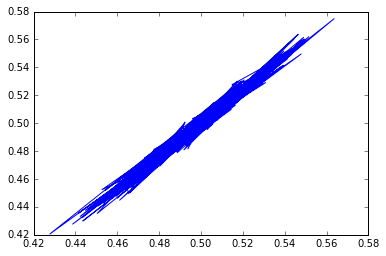

In [70]:
%pylab inline --no-import-all

import numpy as np

x = np.random.randn(1000, 100)

m = np.mean(x, axis=1)

def sigmoid(a):
    return 1.0 / (1 + np.exp(-a))

m_s = sigmoid(m)

m_x_s = np.mean(sigmoid(x), axis=1)

plt.scatter(m_x_s, m_s)
plt.show()
plt.plot(m_x_s, m_s)
plt.show()

### hierarchical softmax

(1)
$$ p(w | w_I) = \prod_{j=1}^{L(w)-1} \sigma \left( [\![ n(w, j+1) = ch(n(w, j)) ]\!] \cdot {v'_{n(w, j)}}^T v_{w_I} 
\right) $$

#### the hierarchical softmax gradient

First let

$$
hs_j = [\![ n(w, j+1) = ch(n(w, j)) ]\!] \cdot {v'_{n(w, j)}}^T v_{w_I}
$$

And

$$
\frac {d hs_j} {v'_{n(w, j)}} = [\![ n(w, j+1) = ch(n(w, j)) ]\!] \cdot v_{w_I}
$$

$$
\frac {d hs_j} {v_{w_I}} = [\![ n(w, j+1) = ch(n(w, j)) ]\!] \cdot v'_{n(w, j)}
$$

Then
$$
\nabla \log p(w | w_I) = \sum_{j=1}^{L(w)-1} \frac{1} {\sigma (hs_j)} \cdot \sigma' (hs_j) \cdot hs'_j
$$

According to equation (0)
$$
\nabla \log p(w | w_I) = \sum_{j=1}^{L(w)-1}
\frac{1} {\sigma (hs_j)}
\cdot
\sigma (hs_j) \cdot [ 1 - \sigma (hs_j) ]
\cdot
hs'_j
$$

simplify
$$
\nabla \log p(w | w_I) = \sum_{j=1}^{L(w)-1}
[ 1 - \sigma (hs_j) ] \cdot hs'_j
$$

When update $ v_{w_I} $, we got gradient is:

$$
\nabla \log p(w | w_I) = \sum_{j=1}^{L(w)-1}
[ 1 - \sigma (hs_j) ] \cdot
[\![ n(w, j+1) = ch(n(w, j)) ]\!]
\cdot v'_{n(w, j)}
$$

When update $ v'_{n(w, j)}$ for each $j \in [1, L(w)-1]$, we got gradient is:

$$
\nabla \log p(w | w_I) = [ 1 - \sigma (hs_j) ]
\cdot
[\![ n(w, j+1) = ch(n(w, j)) ]\!]
\cdot
v_{w_I}
$$

### negative sampling

(2)
$$
\log p(w_O | w_I) = \log \sigma( {v'_{w_O}}^T v_{w_I} ) + 
\sum_{i}^{k} E_{w_i \sim P_n(w)}
\left[
\log \sigma( {-v'_{w_i}}^T v_{w_I} )
\right]
$$

#### the negative sampling gradient

First let

$$
ns_{xI} = {v'_{w_x}}^T \cdot v_{w_I}
$$

$w_x \in \{ w_O, w_i \sim P_n(w) \}$

And

the gradients $ns_{xI}$ according to ${v'_{w_x}}$ and $v_{w_I}$ are:

$$
\frac {d ns_{xI}} {v'_{w_x}} = v_{w_I}
$$

$$
\frac {d ns_{xI}} {v_{w_I}} = v'_{w_x}
$$

Then

$$
\nabla \log p(w_O | w_I) = \frac {1} { \sigma(ns_{OI}) }
\cdot
\sigma'(ns_{OI})
\cdot
ns'_{OI}
+
\sum_{i}^{k} E_{w_i \sim P_n(w)}
\left[
\frac {1} { \sigma(-ns_{iI}) } \cdot
\sigma'( -ns_{iI} ) \cdot
-ns'_{iI}
\right]
$$

According to equation (0)

$$
\nabla \log p(w_O | w_I) = \frac {1} { \sigma(ns_{OI}) }
\cdot
\sigma(ns_{OI}) \cdot [ 1 - \sigma(ns_{OI}) ]
\cdot
ns'_{OI}
+
\sum_{i}^{k} E_{w_i \sim P_n(w)}
\left[
\frac {1} { \sigma(-ns_{iI}) } \cdot
\sigma ( -ns_{iI} ) \cdot
[ 1 - \sigma(-ns_{iI}) ] \cdot
-ns'_{iI}
\right]
$$

simplify

$$
\nabla \log p(w_O | w_I) = [ 1 - \sigma(ns_{OI}) ] \cdot ns'_{OI}
+
\sum_{i}^{k} E_{w_i \sim P_n(w)}
\left[
[ 1 - \sigma(-ns_{iI}) ] \cdot
-ns'_{iI}
\right]
$$

When update $ v'_{w_O} $, we got gradient is:

$$
\nabla \log p(w_O | w_I) = [ 1 - \sigma(ns_{OI}) ] \cdot v_{w_I}
$$

When update $ v_{w_I} $, we got gradient is:

$$
\nabla \log p(w_O | w_I) = [ 1 - \sigma(ns_{OI}) ] \cdot v'_{w_O}
+
\sum_{i}^{k} E_{w_i \sim P_n(w)}
\left[
[ 1 - \sigma(-ns_{iI}) ] \cdot
-v'_{w_i}
\right]
$$

When update $ v'_{w_i}, w_i \sim P_n{w} $, we got gradient is:

$$
\nabla \log p(w_O | w_I) = [ 1 - \sigma(-ns_{iI}) ] \cdot -v_{w_I}
$$

### continuous bag of words

#### maximize the following average log probability:

(3)
$$ \frac{1}{T} \sum_{t=1}^{T} \sum_{-c \leq{j} \leq{c},j\neq{0}} \log{p(w_t | w_{t+j})} $$

I change the index $j$ to index $q$ due to conflict with index $j$ in hierarchical softmax.

(3)
$$ \frac{1}{T} \sum_{t=1}^{T} \sum_{-c \leq{q} \leq{c},q\neq{0}} \log{p(w_t | w_{t+q})} $$

And

$$
\nabla \sum_{-c \leq{q} \leq{c},q\neq{0}} \log{p(w_t | w_{t+q})} = \sum_{-c \leq{q} \leq{c},q\neq{0}}
\nabla \log{p(w_t | w_{t+q})}
$$

#### First compute the mean of window wods vector

Let 
$$
v_{mcw} = \frac{1}  {cw}
\sum_{-c \leq{q} \leq{c},q\neq{0}}
v_{w_{t+q}}
$$

```c
      // window word count
      cw = 0;
      for (a = b; a < window * 2 + 1 - b; a++) if (a != window) {
        // sentence_position is sp
        // c in [sp - (window - b), sp + (window - b)]
        c = sentence_position - window + a;
        if (c < 0) continue;
        // may be is break?
        // because c is increase
        if (c >= sentence_length) continue;
        last_word = sen[c];
        if (last_word == -1) continue;
        // sum window words' vectors
        for (c = 0; c < layer1_size; c++) neu1[c] += syn0[c + last_word * layer1_size];
        cw++;
      }
      
      if (cw) {
        for (c = 0; c < layer1_size; c++) neu1[c] /= cw;
        // ...
```

*`"neu1"` is $v_{mcw}$*

#### when using hierarchical softmax

$w_t$ is $w$, $w_{t+q}$ is $w_I$ in equation(1)

And

$$
hs_j = [\![ n(w_t, j+1) = ch(n(w_t, j)) ]\!] \cdot {v'_{n(w_t, j)}}^T v_{w_{t+q}}
$$

$q \in [-c, c], q\neq{0}$

Then

When update $ v_{w_{t+q}} $ for each $q \in [-c, c], q\neq{0}$, we got gradient is:

$$
\nabla \log p(w_t | w_{t+q}) = \sum_{j=1}^{L(w_t)-1}
[ 1 - \sigma (hs_j) ] \cdot
[\![ n(w_t, j+1) = ch(n(w_t, j)) ]\!]
\cdot v'_{n(w_t, j)}
$$

$$
\nabla \sum_{-c \leq{q} \leq{c},q\neq{0}} \log{p(w_t | w_{t+q})} =
\nabla \log p(w_t | w_{t+q})
$$

When update $ v'_{n(w_t, j)}$ for each $j \in [1, L(w_t)-1]$, we got gradient is:

$$
\nabla \log p(w_t | w_{t+q}) = [ 1 - \sigma (hs_j) ]
\cdot
[\![ n(w_t, j+1) = ch(n(w_t, j)) ]\!]
\cdot
v_{w_{t+q}}
$$

$$
\nabla \sum_{-c \leq{q} \leq{c},q\neq{0}} \log{p(w_t | w_{t+q})} = \sum_{-c \leq{q} \leq{c},q\neq{0}}
[ 1 - \sigma (hs_j) ]
\cdot
[\![ n(w_t, j+1) = ch(n(w_t, j)) ]\!]
\cdot
v_{w_{t+q}}
$$

```c
        if (hs) for (d = 0; d < vocab[word].codelen; d++) {
          f = 0;
          l2 = vocab[word].point[d] * layer1_size;
          // l2 is index j in equation

          // Propagate hidden -> output
          for (c = 0; c < layer1_size; c++) f += neu1[c] * syn1[c + l2];
          // f is +- hs_j
          if (f <= -MAX_EXP) continue;
          else if (f >= MAX_EXP) continue;
          // approximation
          // may be round is better
          else f = expTable[(int)((f + MAX_EXP) * (EXP_TABLE_SIZE / MAX_EXP / 2))];
          // 'g' is the gradient multiplied by the learning rate
          // why sub code[d]?
          // another sigmoid property
          // \sigma(x) = 1 - \sigma(-x)
          // code[d] is 0 or 1
          g = (1 - vocab[word].code[d] - f) * alpha;
          // Propagate errors output -> hidden
          for (c = 0; c < layer1_size; c++) neu1e[c] += g * syn1[c + l2];
          // Learn weights hidden -> output
          for (c = 0; c < layer1_size; c++) syn1[c + l2] += g * neu1[c];
        }
```

From the code We can see that, she or he uses $v_{mcw}$ in place of $v_{w_{t+q}}$

$$
hs_j = [\![ n(w_t, j+1) = ch(n(w_t, j)) ]\!] \cdot {v'_{n(w_t, j)}}^T v_{mcw}
$$

`"syn1[l2]"` is $v'_{n(w_t, j)}$, then `"f"` in the above code before `"expTable"`
is $\pm hs_j$.

And $[ 1 - \sigma (hs_j) ] \cdot
[\![ n(w_t, j+1) = ch(n(w_t, j)) ]\!]$ is `"1 - vocab[word].code[d] - f"` after `"expTable"`, because of the equation:

$$
\sigma(x) = 1 - \sigma(-x)
$$

So `"vocab[word].code[d] == 0"` for $[\![ n(w_t, j+1) = ch(n(w_t, j)) ]\!] = +1$,

and `"vocab[word].code[d] == 1"` for $[\![ n(w_t, j+1) = ch(n(w_t, j)) ]\!] = -1$,

```python
for (c = 0; c < layer1_size; c++) neu1e[c] += g * syn1[c + l2];
```
caculates the gradient of $ v_{w_{t+q}} $ for each $q \in [-c, c], q\neq{0}$

After `for loop "neu1e"` is the added weight vector for each $v_{w_{t+q}}$.

And the gradient of $ v'_{n(w_t, j)}$ for each $j \in [1, L(w_t)-1]$ is caculated as:

$$
\nabla \sum_{-c \leq{q} \leq{c},q\neq{0}} \log{p(w_t | w_{t+q})} = cw \cdot
[ 1 - \sigma (hs_j) ]
\cdot
[\![ n(w_t, j+1) = ch(n(w_t, j)) ]\!]
\cdot
v_{mcw}
$$


The code doesn't multiply cw.
```python
for (c = 0; c < layer1_size; c++) syn1[c + l2] += g * neu1[c];
```
update the $v'_{n(w_t, j)}$ weight vector.

#### when using negative sampling

$w_t is\, w_O$, $w_{t+q} is\, w_I$ in equation(2)

And

$$
ns_{x(t+q)} = {v'_{w_x}}^T \cdot v_{w_{t+q}}
$$

$w_x \in \{ w_t, w_i \sim P_n(w) \}$, $q \in [-c, c], q\neq{0}$

Then

When update $ v'_{w_t} $, we got gradient is:

$$
\nabla \log p(w_t | w_{t+q}) = [ 1 - \sigma(ns_{t(t+q)}) ] \cdot v_{w_{t+q}}
$$

$$
\nabla \sum_{-c \leq{q} \leq{c},q\neq{0}} \log{p(w_t | w_{t+q})} = \sum_{-c \leq{q} \leq{c},q\neq{0}}
[ 1 - \sigma(ns_{t(t+q)}) ] \cdot v_{w_{t+q}}
$$

When update $ v'_{w_i}, w_i \sim P_n{w} $, we got gradient is:

$$
\nabla \log p(w_t | w_{t+q}) = [ 1 - \sigma(-ns_{i(t+q)}) ] \cdot -v_{w_{t+q}}
$$

$$
\nabla \sum_{-c \leq{q} \leq{c},q\neq{0}} \log{p(w_t | w_{t+q})} = \sum_{-c \leq{q} \leq{c},q\neq{0}}
[ 1 - \sigma(-ns_{i(t+q)}) ] \cdot -v_{w_{t+q}}
$$

When update $ v_{w_{t+q}} $, we got gradient is:

$$
\nabla \log p(w_t | w_{t+q}) = [ 1 - \sigma(ns_{t(t+q)}) ] \cdot v'_{w_t}
+
\sum_{i}^{k} E_{w_i \sim P_n(w)}
\left[
[ 1 - \sigma(-ns_{i(t+q)}) ] \cdot
-v'_{w_i}
\right]
$$

$$
\nabla \sum_{-c \leq{q} \leq{c},q\neq{0}} \log{p(w_t | w_{t+q})} =
\nabla \log p(w_t | w_{t+q})
$$

```c
        if (negative > 0) for (d = 0; d < negative + 1; d++) {
          // target is w_O, w_i
          if (d == 0) {
            target = word;
            label = 1;
          } else { // random sample negative weight vector
            next_random = next_random * (unsigned long long)25214903917 + 11;
            target = table[(next_random >> 16) % table_size];
            if (target == 0) target = next_random % (vocab_size - 1) + 1;
            if (target == word) continue;
            label = 0;
          }
          l2 = target * layer1_size;
          f = 0;
          // caculate ns
          // syn1neg[l2] is v', neu1 is v_mcw
          for (c = 0; c < layer1_size; c++) f += neu1[c] * syn1neg[c + l2];
          // caculate gradient
          if (f > MAX_EXP) g = (label - 1) * alpha;
          else if (f < -MAX_EXP) g = (label - 0) * alpha;
          // \sigma(x) = 1 - \sigma(-x), and 0 label for -ns
          else g = (label - expTable[(int)((f + MAX_EXP) * (EXP_TABLE_SIZE / MAX_EXP / 2))]) * alpha;
          // neu1e is added weight vector for each w_{t+q}
          for (c = 0; c < layer1_size; c++) neu1e[c] += g * syn1neg[c + l2];
          // update v'
          for (c = 0; c < layer1_size; c++) syn1neg[c + l2] += g * neu1[c];
        }
```

The code uses $v_{mcw}$ in place of $v_{w_{t+q}}$

$$
ns_{x(t+q)} = {v'_{w_x}}^T \cdot v_{mcw}
$$

$w_x \in \{ w_t, w_i \sim P_n(w) \}$, $q \in [-c, c], q\neq{0}$

the gradient of ${v'_{w_x}},\, w_x \in \{ w_t, w_i \sim P_n(w) \}$ is caculated as:

$$
\nabla \sum_{-c \leq{q} \leq{c},q\neq{0}} \log{p(w_t | w_{t+q})} = cw \cdot
[ 1 - \sigma(\pm ns_{x(mcw)} ) ]
\cdot
\pm v_{w_{mcw}}
$$

The code doesn't multiply `"cw"`

Because the equation $ \sigma(x) = 1 - \sigma(-x)$, 

the gradient of ${v'_{w_x}},\, w_x \in \{ w_t, w_i \sim P_n(w) \}$ is caculated as:

$$
\nabla \sum_{-c \leq{q} \leq{c},q\neq{0}} \log{p(w_t | w_{t+q})} =
  \begin{cases}
    - \sigma( ns_{x(mcw)} ) \cdot v_{w_{mcw}}       & \quad \text{if } -ns_{x(mcw)} \\
    [ 1 - \sigma(ns_{x(mcw)} ) ] \cdot v_{w_{mcw}}  & \quad \text{if } ns_{x(mcw)} \\
  \end{cases}
$$

The code above uses `"label = 0"` to caculate the gradient of $v'_{w_t}$,
`"label = 1"` to caculate the gradient of $v'_{w_i}$,


The gradient of $ v_{w_{t+q}} $ is caculated as:

$$
\nabla \sum_{-c \leq{q} \leq{c},q\neq{0}} \log p(w_t | w_{t+q}) =
[ 1 - \sigma(ns_{x(mcw)} ) ] \cdot v_{w_{mcw}}
+
\sum_{i}^{k} E_{w_i \sim P_n(w)}
\left[
- \sigma( ns_{x(mcw)} ) \cdot v_{w_{mcw}}
\right]
$$


```python
for (c = 0; c < layer1_size; c++) neu1e[c] += g * syn1[c + l2];
```
caculates the gradient of $ v_{w_{t+q}} $ for each $q \in [-c, c], q\neq{0}$

After `for loop "neu1e"` is the added weight vector for each $v_{w_{t+q}}$.

### skip-gram

#### maximize the following average log probability:

(4)
$$ \frac{1}{T} \sum_{t=1}^{T} \sum_{-c \leq{j} \leq{c},j\neq{0}} \log{p(w_{t+j} | w_t)} $$

Same reason, I change the index $j$ to index $q$ due to conflict with index $j$ in hierarchical softmax.

(4)
$$ \frac{1}{T} \sum_{t=1}^{T} \sum_{-c \leq{q} \leq{c}, q\neq{0}} \log{p(w_{t+q} | w_t)} $$

#### when using hierarchical softmax

*TODO*

#### when using negative sampling

*TODO*